# GDP Component Prediction and Visualization

Group Member: Shanmei Liu, Shuhao Zhang

## Introduction

Canada’s economic trajectory hinges on understanding the interplay of its core domestic expenditures—Household Consumption, Business Investment, and Government Spending. Leveraging six decades of quarterly data (1961–2024) from Statistics Canada, https://doi.org/10.25318/3610010401-eng, this study moves beyond aggregate GDP analysis to forecast near-term trends in these critical components. Using Holt’s linear trend and Holt-Winters seasonal models, we predict trajectories for 2023–2024 while isolating seasonal patterns and structural shifts in Investment and Consumption.


By programmatically restructuring raw expenditure subcategories into standardized GDP groupings, we reveal actionable insights about Consumption, Investment, and Government Spending Trends. An interactive forecasting dashboard—built with Plotly—translates these findings into policy-ready visualizations, enabling dynamic comparisons between historical trends and projected scenarios. This approach bridges granular time series analysis with macroeconomic decision-making, offering a pragmatic tool for evaluating fiscal interventions in Canada’s evolving economy.


## Data preprocessing

First, we import the requisite Python libraries and retrieve the quarterly expenditure-based GDP dataset from Statistics Canada in CSV format.

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import plotly.express as px
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np
import plotly.graph_objects as go

In [41]:
real_expenditure_GDP = pd.read_csv("https://raw.githubusercontent.com/MgSO477/Econ323_GDP_prediction/refs/heads/main/data/Expenditure_based_GDP_detail.csv", skiprows=11)
real_expenditure_GDP = real_expenditure_GDP.head(31)

real_expenditure_GDP.head()

,Estimates,Q1 1961,Q2 1961,Q3 1961,Q4 1961,Q1 1962,Q2 1962,Q3 1962,Q4 1962,Q1 1963,...,Q2 2022,Q3 2022,Q4 2022,Q1 2023,Q2 2023,Q3 2023,Q4 2023,Q1 2024,Q2 2024,Q3 2024
0,Final consumption expenditure,"293,535","298,239","306,533","307,087","313,327","317,314","315,469","321,086","324,140",...,"1,865,180","1,872,169","1,877,726","1,891,011","1,895,415","1,905,538","1,907,336","1,922,829","1,931,073","1,948,849"
1,Household final consumption expenditure,"193,805","197,421","202,241","203,009","207,687","208,873","207,986","211,777","213,212",...,"1,323,013","1,323,525","1,324,084","1,336,434","1,339,046","1,341,928","1,346,226","1,356,639","1,359,823","1,371,495"
2,Goods,"85,028","87,370","89,798","89,474","93,335","93,741","93,038","95,494","96,123",...,"582,022","575,343","574,328","581,359","582,850","580,854","585,192","585,983","585,072","591,179"
3,Durable goods,"7,744","8,190","8,933","8,723","9,497","9,479","9,200","9,843","9,882",...,"168,924","165,925","166,084","171,012","170,332","173,431","178,530","178,030","174,014","178,930"
4,Semi-durable goods,"10,318","10,230","10,398","10,728","10,985","11,288","11,158","11,288","11,213",...,"103,856","101,578","101,633","104,592","104,664","100,787","100,725","103,013","103,514","103,935"


*Statistics Canada. Table 36-10-0104-01  Gross domestic product, expenditure-based, Canada, quarterly (x 1,000,000)
DOI: https://doi.org/10.25318/3610010401-eng*

In [42]:
Real_GDP = real_expenditure_GDP.melt(
    id_vars=["Estimates"], 
    var_name="Time",       
    value_name="Value"    )

By systematically categorizing and indexing the dataset according to standardized GDP classifications, we enable precise computation of individual expenditure components aligned with national accounting frameworks.

In [43]:
# group the estimates
group_map = {
    # consumption
    "Final consumption expenditure": "Consumption",
    "Household final consumption expenditure": "Consumption",
    "Goods": "Consumption",
    "Durable goods": "Consumption",
    "Semi-durable goods": "Consumption",
    "Non-durable goods": "Consumption",
    "Services": "Consumption",
    "Non-profit institutions serving households' final consumption expenditure": "Consumption",
    "General governments final consumption expenditure": "Consumption",
    
    # investment
    "Gross fixed capital formation": "Investment",
    "Business gross fixed capital formation": "Investment",
    "Residential structures": "Investment",
    "Non-residential structures, machinery and equipment": "Investment",
    "Non-residential structures": "Investment",
    "Machinery and equipment": "Investment",
    "Intellectual property products": "Investment",
    "Non-profit institutions serving households' gross fixed capital formation": "Investment",
    "General governments gross fixed capital formation": "Investment",
    "Investment in inventories": "Investment",
    "Of which: business investment in inventories": "Investment",
    "Non-farm": "Investment",
    "Farm": "Investment",

    # NE
    "Exports of goods and services": "Net Exports",
    "Exports of goods": "Net Exports",
    "Exports of services": "Net Exports",
    "Less: imports of goods and services": "Net Exports",
    "Imports of goods": "Net Exports",
    "Imports of services": "Net Exports",
    
    # Others
    "Statistical discrepancy": "Others",
    "Gross domestic product at market prices": "Others",
    "Final domestic demand": "Others"
}

Real_GDP['Group'] = Real_GDP['Estimates'].map(group_map)
Real_GDP['Value'] = Real_GDP['Value'].astype(str).str.replace(',', '').astype(float)
Real_GDP.head()

,Estimates,Time,Value,Group
0,Final consumption expenditure,Q1 1961,293535.0,Consumption
1,Household final consumption expenditure,Q1 1961,193805.0,Consumption
2,Goods,Q1 1961,85028.0,Consumption
3,Durable goods,Q1 1961,7744.0,Consumption
4,Semi-durable goods,Q1 1961,10318.0,Consumption


Total consumption is calculated by summing two components: `Household Final Consumption Expenditure` and `Non-Profit Institutions Serving Households' Final Consumption Expenditure`. The quarterly data are aggregated, and the Time column is converted into a datetime-indexed series for time series analysis, by defining the custom function `convert_quarter_to_date`. 

In [44]:
# create the total consumption table
mask = real_expenditure_GDP['Estimates'].isin([
    "Household final consumption expenditure", 
    "Non-profit institutions serving households' final consumption expenditure"
])
subset = real_expenditure_GDP[mask].copy()

time_cols = [col for col in subset.columns if col.startswith("Q")]
for col in time_cols:
    subset[col] = subset[col].astype(str).str.replace(',', '').astype(float)

clean_consumption = subset.melt(
    id_vars=["Estimates"],
    value_vars=time_cols,
    var_name="time",
    value_name="consumption"
)

def convert_quarter_to_date(q_str):
    parts = q_str.split()
    quarter = parts[0] 
    year = parts[1]  
    quarter_to_month = {"Q1": 1, "Q2": 4, "Q3": 7, "Q4": 10}
    month = quarter_to_month.get(quarter, 1)
    return datetime.strptime(f"{year}-{month:02d}-01", "%Y-%m-%d")

clean_consumption['time'] = clean_consumption['time'].apply(convert_quarter_to_date)
clean_consumption = clean_consumption.drop(columns=['Estimates']).groupby("time").sum()
clean_consumption.head()

,consumption
time,
1961-01-01,196797.0
1961-04-01,200550.0
1961-07-01,205473.0
1961-10-01,206271.0
1962-01-01,211052.0


Similarly, we add up `Business gross fixed capital formation` and `Non-profit institutions serving households' gross fixed capital formation` to obtain Total Investment. Also convert the Time column into datatime-indexed series. 

In [45]:
# Total investment table
investment_mask = real_expenditure_GDP['Estimates'].isin([
    "Business gross fixed capital formation",
    "Non-profit institutions serving households' gross fixed capital formation"
])
subset_investment = real_expenditure_GDP[investment_mask].copy()

time_cols = [col for col in subset_investment.columns if col.startswith("Q")]
for col in time_cols:
    subset_investment[col] = subset_investment[col].astype(str).str.replace(',', '').astype(float)

clean_investment = subset_investment.melt(
    id_vars=["Estimates"],
    value_vars=time_cols,
    var_name="time",
    value_name="investment"
)

clean_investment['time'] = clean_investment['time'].apply(convert_quarter_to_date)
clean_investment = clean_investment.drop(columns=['Estimates']).groupby("time").sum()
clean_investment.head()

,investment
time,
1961-01-01,50342.0
1961-04-01,50486.0
1961-07-01,52168.0
1961-10-01,51834.0
1962-01-01,51595.0


Total Government Spending is the sum of `General governments final consumption expenditure` and `General governments gross fixed capital formation`. 

In [46]:
# Total government spending table
gov_mask = real_expenditure_GDP['Estimates'].isin([
    "General governments final consumption expenditure",
    "General governments gross fixed capital formation"
])
subset_gov = real_expenditure_GDP[gov_mask].copy()

time_cols = [col for col in subset_gov.columns if col.startswith("Q")]
for col in time_cols:
    subset_gov[col] = subset_gov[col].astype(str).str.replace(',', '').astype(float)

clean_gov = subset_gov.melt(
    id_vars=["Estimates"],
    value_vars=time_cols,
    var_name="time",
    value_name="gov_spending"
)

clean_gov['time'] = clean_gov['time'].apply(convert_quarter_to_date)
clean_gov= clean_gov.drop(columns=['Estimates']).groupby("time").sum()
clean_gov.head()

,gov_spending
time,
1961-01-01,112816.0
1961-04-01,114737.0
1961-07-01,119348.0
1961-10-01,119115.0
1962-01-01,121328.0


## Visualization

This section constructs an interactive line plot of Canada’s GDP components (1961–2024), focusing on Consumption, Investment, and Government Spending. The visualization enables comparative analysis of long-term trends, compositional shifts, and growth trajectories, empowering readers to interrogate how each expenditure category evolved over six decades of economic cycles.

First, we combine all the separate data tables into a single dataset for analysis.

In [47]:
component_GDP = clean_consumption.merge(clean_investment, on="time").merge(clean_gov, on = "time")

component_GDP = component_GDP.reset_index() 
component_GDP["time"] = pd.to_datetime(component_GDP["time"])
GDP_long = component_GDP.melt(id_vars=["time"], var_name="Category", value_name="Value")
GDP_long.head()

,time,Category,Value
0,1961-01-01,consumption,196797.0
1,1961-04-01,consumption,200550.0
2,1961-07-01,consumption,205473.0
3,1961-10-01,consumption,206271.0
4,1962-01-01,consumption,211052.0


Then we build an interactive line chart to visualize Canada’s GDP components (1961–2024). The dropdown menu allows users to toggle between Consumption, Investment, or Government Spending. Native Plotly tools (zoom, pan, hover) allow users inspect quarterly values by hovering or zooming into specific timeframes (such as 2008 financial crisis). The hover tooltip (auto-generated by Plotly) displays exact dates and expenditure values. 

In [48]:
fig = px.line(GDP_long, 
              x="time", 
              y="Value", 
              color="Category", 
              title="Interactive GDP Component Visualization",
              labels={"Value": "Real Expenditure", "time": "Year"},
              template="plotly_white")


fig.update_layout(
    updatemenus=[{
        "buttons": [
            {
                "label": "All",
                "method": "update",
                "args": [
                    {"visible": [True, True, True]},
                    {"title": "All GDP Components"}
                ]
            },
            {
                "label": "Consumption",
                "method": "update",
                "args": [
                    {"visible": [True, False, False]},
                    {"title": "Household Consumption"}
                ]
            },
            {
                "label": "Investment",
                "method": "update",
                "args": [
                    {"visible": [False, True, False]},
                    {"title": "Business Investment"}
                ]
            },
            {
                "label": "Government Spending",
                "method": "update",
                "args": [
                    {"visible": [False, False, True]},
                    {"title": "Government Spending"}
                ]
            }
        ],
        "direction": "down",
        "showactive": True,
        "x": 0.1,
        "xanchor": "left",
        "y": 1.15,
        "yanchor": "top"
    }]
)


fig.show()

## Prediction

As the plot of consumption and government spending shows obvious trend without obvious seasonal effects, it is suitable to to use Holt's method.

In [49]:
consumption = clean_consumption.copy()
consumption = consumption.asfreq("QS")
train_cons = consumption.loc[:'2022-12-31']
test_cons = consumption.loc['2023-01-01':]
print(train_cons.head())
print(test_cons.head())

            consumption
time                   
1961-01-01     196797.0
1961-04-01     200550.0
1961-07-01     205473.0
1961-10-01     206271.0
1962-01-01     211052.0
            consumption
time                   
2023-01-01    1373422.0
2023-04-01    1376434.0
2023-07-01    1379400.0
2023-10-01    1383902.0
2024-01-01    1394627.0


In [50]:
holt_model_cons = Holt(
    train_cons['consumption'],
    initialization_method='estimated'
).fit(optimized=True)
steps_ahead = len(test_cons)
forecast_cons = holt_model_cons.forecast(steps=steps_ahead)
forecast_cons = forecast_cons.to_frame(name = "estimates")
print(forecast_cons)

               estimates
2023-01-01  1.368296e+06
2023-04-01  1.374543e+06
2023-07-01  1.380791e+06
2023-10-01  1.387038e+06
2024-01-01  1.393285e+06
2024-04-01  1.399532e+06
2024-07-01  1.405779e+06


/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



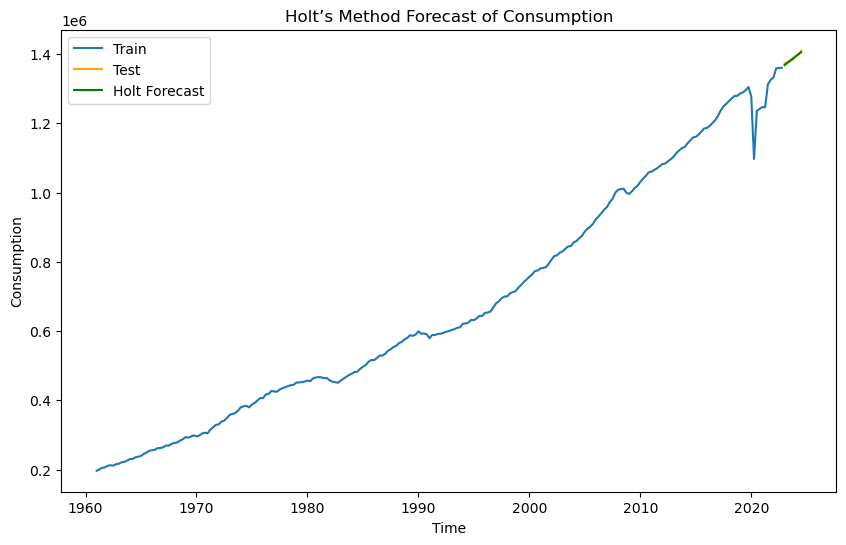

In [51]:
plt.figure(figsize=(10, 6))
plt.plot(train_cons.index, train_cons['consumption'], label='Train')
plt.plot(test_cons.index, test_cons['consumption'], label='Test', color='orange')
plt.plot(forecast_cons.index, forecast_cons, label='Holt Forecast', color='green')
plt.title("Holt’s Method Forecast of Consumption")
plt.xlabel("Time")
plt.ylabel("Consumption")
plt.legend()
plt.show()

In [52]:
investment = clean_investment.copy()
investment = investment.asfreq("QS")
train_inv = investment.loc[:'2022-12-31']
test_inv = investment.loc['2023-01-01':]
print(train_inv.head())
print(test_inv.head())

            investment
time                  
1961-01-01     50342.0
1961-04-01     50486.0
1961-07-01     52168.0
1961-10-01     51834.0
1962-01-01     51595.0
            investment
time                  
2023-01-01    419744.0
2023-04-01    427006.0
2023-07-01    422959.0
2023-10-01    414947.0
2024-01-01    414079.0


In [53]:
model = ExponentialSmoothing(
    train_inv,             
    trend='add',           
    seasonal='add',        
    seasonal_periods=4    
)
model_fit = model.fit()
steps_to_forecast_inv = len(test_inv)
forecast_inv = model_fit.forecast(steps=steps_to_forecast_inv)
forecast_inv = forecast_inv.to_frame(name = "estimates")
print(forecast_inv)

                estimates
2023-01-01  421468.027097
2023-04-01  421791.774160
2023-07-01  423180.976037
2023-10-01  424392.585699
2024-01-01  424438.345385
2024-04-01  424762.092448
2024-07-01  426151.294326


/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



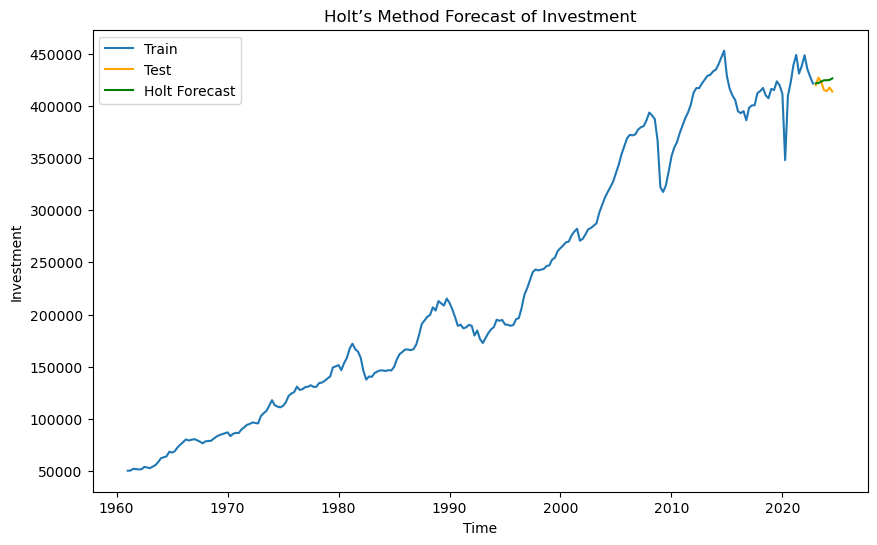

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(train_inv.index, train_inv['investment'], label='Train')
plt.plot(test_inv.index, test_inv['investment'], label='Test', color='orange')
plt.plot(forecast_inv.index, forecast_inv, label='Holt Forecast', color='green')
plt.title("Holt’s Method Forecast of Investment")
plt.xlabel("Time")
plt.ylabel("Investment")
plt.legend()
plt.show()

In [55]:
gov = clean_gov.copy()
gov = gov.asfreq("QS")
train_gov = gov.loc[:'2022-12-31']
test_gov = gov.loc['2023-01-01':]
print(train_gov.head())
print(test_gov.head())

            gov_spending
time                    
1961-01-01      112816.0
1961-04-01      114737.0
1961-07-01      119348.0
1961-10-01      119115.0
1962-01-01      121328.0
            gov_spending
time                    
2023-01-01      605228.0
2023-04-01      606421.0
2023-07-01      614357.0
2023-10-01      613120.0
2024-01-01      617989.0


In [56]:
holt_model_gov = Holt(
    train_gov['gov_spending'],
    initialization_method='estimated'
).fit(optimized=True)
steps_ahead_gov = len(test_gov)
forecast_gov = holt_model_gov.forecast(steps=steps_ahead_gov)
forecast_gov = forecast_gov.to_frame(name = "estimates")
print(forecast_gov)

                estimates
2023-01-01  604843.284889
2023-04-01  608909.329721
2023-07-01  612975.374552
2023-10-01  617041.419384
2024-01-01  621107.464215
2024-04-01  625173.509047
2024-07-01  629239.553878


/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



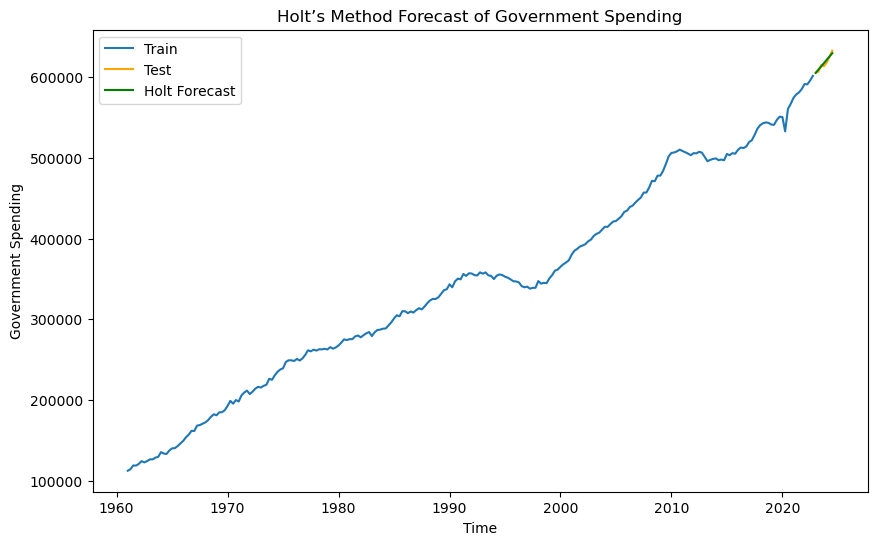

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(train_gov.index, train_gov['gov_spending'], label='Train')
plt.plot(test_gov.index, test_gov['gov_spending'], label='Test', color='orange')
plt.plot(forecast_gov.index, forecast_gov, label='Holt Forecast', color='green')
plt.title("Holt’s Method Forecast of Government Spending")
plt.xlabel("Time")
plt.ylabel("Government Spending")
plt.legend()
plt.show()

## Interactive visualization for prediction model

We prepare our data by defining a helper function called `prepare_series()` that resets the DataFrame index so that the time information becomes a column. In this function, we also rename the value column to "Value" and add labels for both the series type (Train, Test, or Forecast) and the category (for example, "Consumption"). For our forecast DataFrames, we explicitly reset the index to ensure that the time information is stored in a column named `time`.

Next, we merge the processed DataFrames for Consumption, Investment, and Government Spending into a single DataFrame called `combined_df`. We sort the data so that all data points are in the correct chronological order, ensuring that our visualization will accurately reflect the temporal progression of the data.

In [58]:
def prepare_series(df, value_col, series_label, category_label):
    df = df.copy()
    df = df.reset_index()  # Make 'time' a column
    return df.rename(columns={value_col: "Value"}).assign(Series=series_label, Category=category_label)

cons_train_df = prepare_series(train_cons, "consumption", "Train", "Consumption")
cons_test_df = prepare_series(test_cons, "consumption", "Test", "Consumption")
forecast_cons = forecast_cons.reset_index().rename(columns={"index": "time"})
cons_forecast_df = prepare_series(forecast_cons, "estimates", "Forecast", "Consumption")

inv_train_df = prepare_series(train_inv, "investment", "Train", "Investment")
inv_test_df = prepare_series(test_inv, "investment", "Test", "Investment")
forecast_inv = forecast_inv.reset_index().rename(columns={"index": "time"})
inv_forecast_df = prepare_series(forecast_inv, "estimates", "Forecast", "Investment")

gov_train_df = prepare_series(train_gov, "gov_spending", "Train", "Government Spending")
gov_test_df = prepare_series(test_gov, "gov_spending", "Test", "Government Spending")
forecast_gov = forecast_gov.reset_index().rename(columns={"index": "time"})
gov_forecast_df = prepare_series(forecast_gov, "estimates", "Forecast", "Government Spending")

combined_df = pd.concat([
    cons_train_df, cons_test_df, cons_forecast_df,
    inv_train_df, inv_test_df, inv_forecast_df,
    gov_train_df, gov_test_df, gov_forecast_df
])


combined_df["time"] = pd.to_datetime(combined_df["time"])

combined_df = combined_df.sort_values(by="time")

Finally, we create an interactive visualization using Plotly’s `go.Figure()`. We add a trace for each combination of GDP component and data series (Train, Test, Forecast). To make the visualization interactive, we define visibility arrays and incorporate a dropdown menu via the updatemenus option. This allows users to toggle between viewing all components or a specific component (Consumption, Investment, or Government Spending) interactively. Through these steps, we enable dynamic comparison of historical data and forecasts for each GDP component.

In [59]:
# interactive visualization
fig = go.Figure()


categories = ["Consumption", "Investment", "Government Spending"]
series_order = ["Train", "Test", "Forecast"]

for cat in categories:
    for series in series_order:
        df_sub = combined_df[(combined_df["Category"] == cat) & (combined_df["Series"] == series)]
        # Add a trace only if data exists for that combination.
        if not df_sub.empty:
            fig.add_trace(
                go.Scatter(
                    x=df_sub["time"],
                    y=df_sub["Value"],
                    mode='lines+markers',
                    name=f"{cat} {series}"
                )
            )


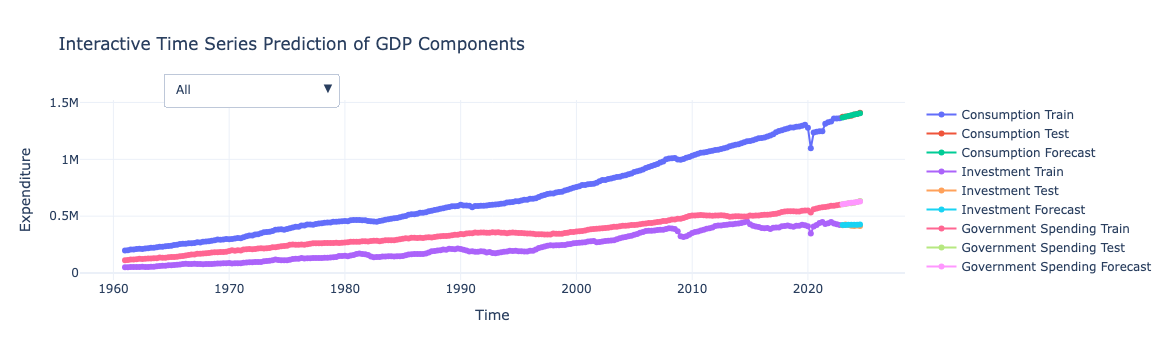

In [60]:
visible_all = [True] * len(fig.data)

visible_consumption = [True, True, True] + [False] * 6
visible_investment = [False] * 3 + [True, True, True] + [False] * 3
visible_gov = [False] * 6 + [True, True, True]


fig.update_layout(
    title="Interactive Time Series Prediction of GDP Components",
    xaxis_title="Time",
    yaxis_title="Expenditure",
    template="plotly_white",
    updatemenus=[{
        "buttons": [
            {
                "label": "All",
                "method": "update",
                "args": [{"visible": visible_all},
                         {"title": "All GDP Components Predictions"}]
            },
            {
                "label": "Consumption",
                "method": "update",
                "args": [{"visible": visible_consumption},
                         {"title": "Consumption Predictions"}]
            },
            {
                "label": "Investment",
                "method": "update",
                "args": [{"visible": visible_investment},
                         {"title": "Investment Predictions"}]
            },
            {
                "label": "Government Spending",
                "method": "update",
                "args": [{"visible": visible_gov},
                         {"title": "Government Spending Predictions"}]
            }
        ],
        "direction": "down",
        "showactive": True,
        "x": 0.1,
        "xanchor": "left",
        "y": 1.15,
        "yanchor": "top"
    }]
)

fig.show()

## Discussion 

### Model prediction and visualization result

### Limitation 